<a href="https://colab.research.google.com/github/fjamshidi80/CameraCalibration/blob/main/MacDon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import random
import keras
from keras import layers
#import numpy as np
#import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import zipfile
from PIL import Image, UnidentifiedImageError  # Import UnidentifiedImageError

In [ ]:
class_names = [ 'Cutterbar hesitation', 'Good flow', 'Hesitation left draper', 'Hesitation right draper','Plugging', 'RTD Hesitation']
width=200;
length=800;

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
extracted_folder = '/content/drive/MyDrive/Fatemeh Mitacs PDF/CrossFlow/CrossFlow'
root_folder =sorted( [subfolder for subfolder in os.listdir(extracted_folder) if os.path.isdir(os.path.join(extracted_folder, subfolder))])


Mounted at /content/drive


In [ ]:
def load_and_split_images(extracted_folder, target_size, test_size=0.2):
    root_folder = sorted([subfolder for subfolder in os.listdir(extracted_folder) if os.path.isdir(os.path.join(extracted_folder, subfolder))])

    #print(classes)
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    images=[]
    labels=[]
    class_idx=0
    #for class_idx, class_name in enumerate(classes):
    for subfolder in root_folder:
        class_folder = os.path.join(extracted_folder, subfolder)
        #class_folder = os.path.join(extracted_folder, class_name)
        #print(class_folder)
        ii=0
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
              img = Image.open(img_path)
              if os.path.isfile(img_path):
                ii=ii+1
                if ii % 2 == 0:
                  img = img.resize(target_size)  # Resize if needed
                  img_array = np.array(img)
                  images.append(img_array)
                  labels.append(class_idx)
            except (UnidentifiedImageError, OSError):
              print(f"Could not open image: {img_path}. Skipping...")
            continue
        class_idx+=1
    num_train = int(len(images) * (1 - test_size))
    # Randomly select images and get their indices
    selected_indices = random.sample(range(len(images)), num_train)
    train_images =np.array( [images[i] for i in selected_indices])
    train_labels = np.array([labels[i] for i in selected_indices])
    # Remaining images are for the test set
    test_images =np.array( [images[i] for i in range(len(images)) if i not in selected_indices])
    test_labels = np.array([labels[i] for i in range(len(labels)) if i not in selected_indices])
    return train_images,train_labels,test_images,test_labels

In [ ]:
target_size = (width, length)  # Adjust to your desired image size
train_images,train_labels,test_images,test_labels = load_and_split_images(extracted_folder, target_size, test_size=0.2)

Could not open image: /content/drive/MyDrive/Fatemeh Mitacs PDF/CrossFlow/CrossFlow/Cutterbar hesitation/2563.jpg. Skipping...


In [ ]:
# Now you have your training and test sets ready
print("Train images shape:",(train_images).shape )
print("Train labels shape:", (train_labels).shape)
print("Test images shape:", (test_images).shape)
print("Test labels shape:", (test_labels).shape)

Train images shape: (3116, 800, 200)
Train labels shape: (3116,)
Test images shape: (780, 800, 200)
Test labels shape: (780,)


In [ ]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
class_names = [ 'Cutterbar hesitation', 'Good flow', 'Hesitation left draper', 'Hesitation right draper','Plugging', 'RTD Hesitation']

In [ ]:
# model...
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(width,length,1)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
#model.add(layers.Dense(64, activation='relu'))
##'sigmoid' 'tanh' 'linear' 'elu'
##'tf.keras.layers.LeakyReLU(alpha=0.2)
## tf.keras.layers.PReLU()
## tf.keras.layers.Swish()
model.add(layers.Dense(64, activation='sigmoid'))
#model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(6, activation='softmax'))
print(model.summary())
#import sys; sys.exit()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 798, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 399, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 397, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 198, 32)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 304128)            0         
                                                                 
 dropout (Dropout)           (None, 304128)            0

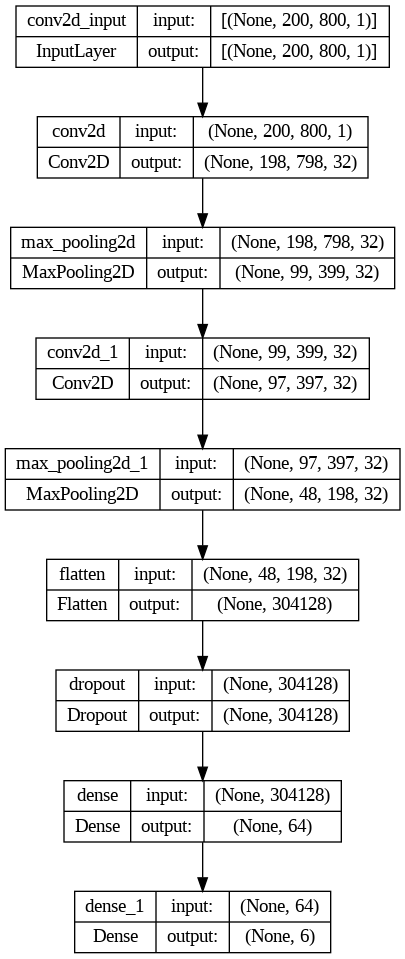

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot the model architecture
plt.figure(figsize=(10, 6))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True)

In [ ]:
train_images = train_images.reshape(-1, width, length, 1)
test_images = test_images.reshape(-1, width, length, 1)
optim = keras.optimizers.Adam(learning_rate=0.001)

# loss and optimizer
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
##model.add(layers.Dense(6))
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

# training
batch_size = 8
num_epochs = 5
model.fit(train_images, train_labels, epochs=num_epochs,
          batch_size=batch_size, verbose=2)

Epoch 1/5
390/390 - 751s - loss: 0.1400 - accuracy: 0.9618 - 751s/epoch - 2s/step
Epoch 2/5
390/390 - 747s - loss: 0.0063 - accuracy: 1.0000 - 747s/epoch - 2s/step
Epoch 3/5
390/390 - 743s - loss: 0.0030 - accuracy: 1.0000 - 743s/epoch - 2s/step
Epoch 4/5
390/390 - 747s - loss: 0.0018 - accuracy: 1.0000 - 747s/epoch - 2s/step
Epoch 5/5
390/390 - 748s - loss: 0.0011 - accuracy: 1.0000 - 748s/epoch - 2s/step


In [ ]:
# evaluate
model.evaluate(test_images,  test_labels, batch_size=batch_size, verbose=2)

98/98 - 44s - loss: 9.5120e-04 - accuracy: 1.0000 - 44s/epoch - 447ms/step


[0.0009512028773315251, 1.0]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Assuming you have predicted labels for the test data
test_predicted_labels = model.predict(test_images)
test_predicted_labels = np.argmax(test_predicted_labels, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predicted_labels)
precision = precision_score(test_labels, test_predicted_labels, average='weighted')
recall = recall_score(test_labels, test_predicted_labels, average='weighted')
f1 = f1_score(test_labels, test_predicted_labels, average='weighted')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Classification report
print("Classification Report:\n", classification_report(test_labels, test_predicted_labels))

# Confusion matrix
cm = confusion_matrix(test_labels, test_predicted_labels)
print("Confusion Matrix:\n", cm)


25/25 [==============================] - 55s 2s/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00       170
           3       1.00      1.00      1.00       103
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00       108

    accuracy                           1.00       780
   macro avg       1.00      1.00      1.00       780
weighted avg       1.00      1.00      1.00       780

Confusion Matrix:
 [[322   0   0   0   0   0]
 [  0  51   0   0   0   0]
 [  0   0 170   0   0   0]
 [  0   0   0 103   0   0]
 [  0   0   0   0  26   0]
 [  0   0   0   0   0 108]]


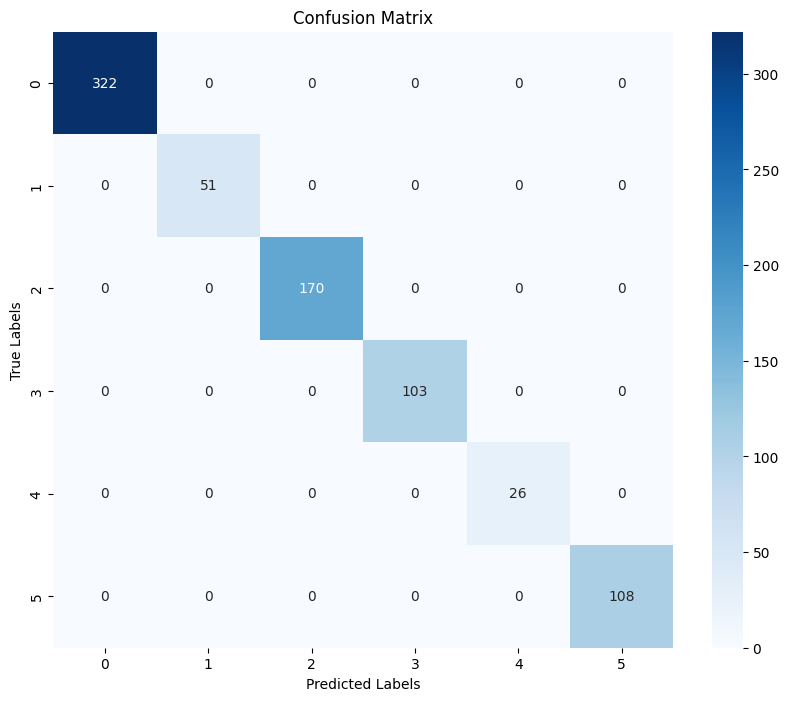

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(6), yticklabels=np.arange(6))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
img_path = '/7857.jpg'

img = Image.open(img_path)
img = img.resize(target_size)  # Resize if needed
img_array = np.array(img)
img_array = img_array.reshape(-1, width, length, 1)
test_predictions = model.predict(img_array)
indices = np.argmax(test_predictions)

1/1 [==============================] - 0s 340ms/step


In [ ]:
print(class_names[indices])

RTD Hesitation


In [ ]:
class_folder = /7857.jpg
Result=[]
for filename in os.listdir(class_folder):
    img_path = os.path.join(class_folder, filename)
    if os.path.isfile(img_path):
        img = Image.open(img_path)
        img = img.resize(target_size)  # Resize if needed
        img_array = np.array(img)
        img_array = img_array.reshape(-1, width, length, 1)
        test_predictions = model.predict(img_array)
        indices = np.argmax(test_predictions)
        Result.append(indices)
#print(Result)

In [ ]:
for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
              img = Image.open(img_path)
              if os.path.isfile(img_path):
                ii=ii+1
                if ii % 2 == 0:
                  img = img.resize(target_size)  # Resize if needed
                  img_array = np.array(img)

In [ ]:
True_Result = [0] * 10 + [1] * 10 + [2] * 10+[3] * 10 + [4] * 10 + [5] * 10
differences = 0

for i in range(len(Result)):
    if Result[i] != True_Result[i]:
        differences += 1
combined = "The percentage of error is:  " + str(differences)+" %"
print(combined)